<a href="https://colab.research.google.com/github/aliwagdy2580/NLP/blob/aliwagdy2580-patch-1/IMDB_Classifying_movie_reviews_with_BoW_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.datasets import imdb
from keras import layers
from keras import models
from keras import optimizers

from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
stop_words=stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Classifying movie reviews with BoW model**

# The IMDB dataset

We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

In [2]:
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

In [3]:
print(train_data.shape)
print(test_data.shape)
print(train_data[0])

(25000,)
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
train_labels[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

Since we restricted ourselves to the top 10,000 most frequent words, no word 
index will exceed 10,000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index=imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [8]:
def vectorize_sequences(sequences,dimension=10000):
   # Create an all-zero matrix of shape (len(sequences), dimension)
  bag=np.zeros((len(sequences),dimension))
  for i,sequences in enumerate(sequences):
    bag[i,sequences]=1
  return bag

# Our vectorized training data
x_train=vectorize_sequences(train_data)
# Our vectorized test data
x_test=vectorize_sequences(test_data)

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels

In [10]:
y_train=np.array(train_labels).astype('float32')
y_test=np.array(test_labels).astype('float32')

In [11]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

# **Building our network**

In [12]:
model=models.Sequential()
model.add(layers.Dense(16 , activation='relu' , input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [13]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

# split train dataset to train and validation
In order to monitor during training the accuracy of the model on data that it has never seen before,

In [14]:
X_train,X_val ,y_train,y_val=train_test_split(x_train,y_train,test_size=0.3,random_state=44)

In [15]:
print('X_train',X_train.shape)
print('X_val',X_val.shape)
print('y_train',y_train.shape)
print('y_val',y_val.shape)

X_train (17500, 10000)
X_val (7500, 10000)
y_train (17500,)
y_val (7500,)


We will now train our model for 30 epochs (30 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples.

In [16]:
history=model.fit(X_train,y_train , batch_size=512 , epochs=30 , validation_data=(X_val,y_val))

Epoch 1/30
35/35 [==============================] - 16s 50ms/step - loss: 0.5764 - accuracy: 0.7071 - val_loss: 0.3512 - val_accuracy: 0.8775
Epoch 2/30
35/35 [==============================] - 1s 37ms/step - loss: 0.2993 - accuracy: 0.9068 - val_loss: 0.2896 - val_accuracy: 0.8892
Epoch 3/30
35/35 [==============================] - 1s 32ms/step - loss: 0.2127 - accuracy: 0.9339 - val_loss: 0.2685 - val_accuracy: 0.8911
Epoch 4/30
35/35 [==============================] - 1s 32ms/step - loss: 0.1695 - accuracy: 0.9444 - val_loss: 0.3018 - val_accuracy: 0.8785
Epoch 5/30
35/35 [==============================] - 1s 32ms/step - loss: 0.1420 - accuracy: 0.9555 - val_loss: 0.2756 - val_accuracy: 0.8916
Epoch 6/30
35/35 [==============================] - 1s 32ms/step - loss: 0.1176 - accuracy: 0.9645 - val_loss: 0.2864 - val_accuracy: 0.8908
Epoch 7/30
35/35 [==============================] - 1s 32ms/step - loss: 0.0977 - accuracy: 0.9696 - val_loss: 0.3130 - val_accuracy: 0.8813
Epoch 8/30
3

In [17]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

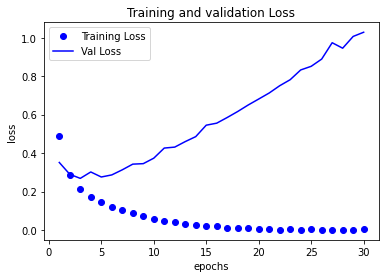

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)
plt.plot(epochs , loss ,'bo',label='Training Loss')
plt.plot(epochs , val_loss ,'b',label='Val Loss')
plt.title('Training and validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

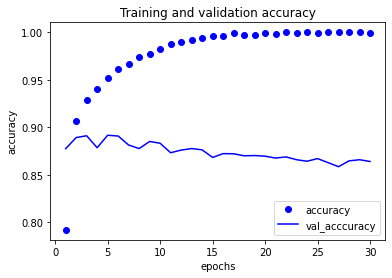

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs , acc,'bo',label='accuracy')
plt.plot(epochs , val_acc ,'b',label='val_acccuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
